In [76]:
import numpy as np
import os
import subprocess
import theano

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11254009917538055173
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1436473753
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1438412614901041522
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [78]:
TRAIN_PATH = 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'
TEST_PATH =  'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

In [79]:
def load_gz(path):  # load a .npy.gz file
    if path.endswith(".gz"):
        f = open(path, 'rb')
        return np.load(f)
    else:
        return np.load(path)

In [80]:
def get_train(path=TRAIN_PATH):
    if not os.path.isfile(path):
        print("Train path is not downloaded ...")
        subprocess.call("./download_train.sh", shell=True)
    else:
        print("Train path is downloaded ...")
    print("Loading train data ...")
    X_in = load_gz(path)
    X = np.reshape(X_in, (5534, 700, 57))
    del X_in
    X = X[:, :, :].astype(theano.config.floatX)
  
    seq_names = np.arange(0, np.size(X, 0))

    X_train = X[seq_names[0:5278]]
    X_valid = X[seq_names[5278:5534]]
    
    return X_train, X_valid

In [81]:
X_train, X_valid= get_train(TRAIN_PATH)
print("Done loading train")
print(X_train.shape)

Train path is downloaded ...
Loading train data ...
Done loading train
(5278, 700, 57)


In [82]:
def get_test(path=TEST_PATH):
    if not os.path.isfile(path):
        subprocess.call("./download_test.sh", shell=True)
    print("Loading test data ...")
    X_test_in = load_gz(path)
    X_test = np.reshape(X_test_in, (514, 700, 57))
    del X_test_in
    X_test = X_test[:, :, :].astype(theano.config.floatX)

    return X_test

In [83]:
X_test = get_test(TEST_PATH)
print("Done loading test")
print(X_test.shape)

Loading test data ...
Done loading test
(514, 700, 57)


In [85]:
#To do: Make 1 hot encoded class - from Q8 to Q3
       #Reshape the dataset so it has 700*windowSize seq that map to a class
       #Look inside lasagne to see how we disregard the padding
##

def q8ClassToQ3(q8Labels):
    
    q3 = np.zeros(3)
    index = np.argmax(q8Labels)
    
    #Helix
    if index == 5 or index == 3 or index == 4 : # H ,G, I
        q3[0] = 1   
    #beta    
    if index == 1 or index == 2: # B, E
        q3[1] = 1    
    #coil    
    if index == 7 or index == 6 or index == 0 : # T, S, L
        q3[2] = 1
    return q3

def q8ClassToQ2(q8Labels):
    
    q2 = np.zeros(2)
    index = np.argmax(q8Labels)
    #Helix
    if index == 5: # or index == 3 or index == 4 : # H ,G, I
        q2[0] = 1
    else:
        q2[1] = 1  
    return q2

def changeQ8Class(dataSet, reductionFunction, numberOfFeatures):

    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    labels_new = np.zeros((num_seqs, seqlen, numberOfFeatures))

    for i in range(np.size(dataSet, axis=0)):
        for j in range(np.size(dataSet, axis=1)):
            oneHot = reductionFunction(dataSet[i, j, 22:30])
            features = np.concatenate((dataSet[i, j, 0:21], oneHot), axis=None)
            features = np.concatenate((features, dataSet[i, j, 35:56]), axis=None)
            labels_new[i][j] = features
    return labels_new


In [86]:
def swapClassLabel(features, classLabel, classSize):

    res = np.concatenate((features[0:21], classLabel), axis=None)
    res = np.concatenate((res, features[ (21+classSize) :]), axis=None)
  
    return res

In [87]:
import math

#num_classes should be q8, q3 or maybe q2?
def proteinSequenceToWindowSequence(windowSize, predictionIndex , dataSet, classSize):
   
    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    features = np.size(dataSet, 2)
    dataSet_new = np.zeros((num_seqs, seqlen - windowSize + 1, windowSize, features))
    
    for i in range(np.size(dataSet, axis=0)):
        if i % 100 == 0:
            print(i)
        for j in range(np.size(dataSet, axis=1) - windowSize + 1):
            classLabel = dataSet[i][j + predictionIndex][21 : (21+classSize) ]
            for k in range(windowSize):
                dataSet_new[i][j][k] = swapClassLabel(dataSet[i][j+k], classLabel, classSize)
            
    return dataSet_new    

In [88]:
def removeWindowsWithPadding(dataSet, windowSize, numberOfFeatures):
    
    dataSet = np.reshape(dataSet, (dataSet.shape[0]*dataSet.shape[1], windowSize, numberOfFeatures))
    dataSet = dataSet[np.count_nonzero( dataSet, axis=(1,2))>(int(windowSize/2)*numberOfFeatures), :, :] 
    
    return dataSet

In [89]:
def get_reshaped_dataset(X_train, X_valid, reductionFunction, numberOfFeatures):
    print(X_train.shape)
    X_train = changeQ8Class(X_train, reductionFunction, numberOfFeatures)
    print(X_train.shape, "changed train data to class of size ", classSize)
    X_train_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_train, classSize)
    print(X_train_window.shape, "changed train data  to window sequence of size ", windowSize)
    X_train_window = removeWindowsWithPadding(X_train_window , windowSize, numberOfFeatures)
    print(X_train_window.shape, "filtered windows withouth padding of train data ")

    print(X_valid.shape)
    X_valid = changeQ8Class(X_valid, reductionFunction, numberOfFeatures)
    print(X_valid.shape, "changed validation data to class size ", classSize)
    X_valid_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_valid, classSize)
    print(X_valid_window.shape, "changed validation data to window sequence of size ", windowSize)
    X_valid_window = removeWindowsWithPadding(X_valid_window , windowSize, numberOfFeatures)
    print(X_valid_window.shape, "filtered windows withouth padding of validation data")
    
    return X_train_window, X_valid_window

In [112]:
def get_split(X_train, X_valid, classSize, pssm = False):

    if not pssm:
        return (X_train[:,:,0:21], X_train[:,:,21 : (21+classSize)], 
                X_valid[:,:,0:21], X_valid[:,:,21 : (21+classSize)])
    else:
        return (X_train[:,:,21+classSize:], X_train[:,:,21 : (21+classSize)],
                X_valid[:,:,21+classSize:], X_valid[:,:,21 : (21+classSize)])

In [97]:
windowSize = 9
predictionIndex = 8
classSize = 2  # 2 or 3 
numberOfFeatures = 44

amino_acid_residues = 21
num_classes = 2

In [98]:
X_train_window, X_valid_window = get_reshaped_dataset(X_train, X_valid, q8ClassToQ2, numberOfFeatures)

(5278, 700, 57)
(5278, 700, 44) changed train data to class of size  2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
(5278, 692, 9, 44) changed train data  to window sequence of size  9
(1092916, 9, 44) filtered windows withouth padding of train data 
(256, 700, 57)
(256, 700, 44) changed validation data to class size  2
0
100
200
(256, 692, 9, 44) changed validation data to window sequence of size  9
(51664, 9, 44) filtered windows withouth padding of validation data


NameError: name 'x_valid' is not defined

In [113]:
x_train_final, y_train_final, x_valid_final, y_valid_final = get_split(X_train_window, X_valid_window, classSize, pssm = True)
print(x_train_final.shape, "training data")
print(y_train_final.shape, "labels for training data")
print(x_valid_final.shape, "validation data")
print(y_valid_final.shape, "labels for training validation")

(1092916, 9, 21) training data
(1092916, 9, 2) labels for training data
(51664, 9, 21) validation data
(51664, 9, 2) labels for training validation


In [119]:
print(y_train_final[0][0])

[0. 1.]


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.regularizers import l2

LR = 0.0005
drop_out = 0.3
batch_dim = 64
nn_epochs = 10

loss = 'categorical_crossentropy'


m = Sequential()
m.add(Conv1D(128, 11, padding='same', activation='relu', input_shape=(windowSize, amino_acid_residues)))
m.add(Dropout(drop_out))
m.add(Conv1D(64, 11, padding='same', activation='relu'))
m.add(Dropout(drop_out))
m.add(Conv1D(num_classes, 11, padding='same', activation='softmax'))
opt = optimizers.Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
print("\nLoss: " + loss + "\n")
m.summary()


Hyper Parameters

Learning Rate: 0.0005
Drop out: 0.3
Batch dim: 64
Number of epochs: 10

Loss: categorical_crossentropy

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 9, 128)            29696     
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 9, 64)             90176     
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 9, 2)              1410      
Total params: 121,282
Trainable params: 121,282
Non-trainable params: 0
_________________________________________________________

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import regularizers


LR = 0.0005
drop_out = 0.3
batch_dim = 64
nn_epochs = 10
w_reg = regularizers.l2(0.0001)
number_filters = 16

loss = 'categorical_crossentropy'


m = Sequential()

#first convolutional neural netwok
m.add(Conv1D( 128, 3,  strides=1, padding='same', activation='relu', use_bias=True, input_shape=(windowSize, amino_acid_residues), kernel_regularizer=w_reg))
m.add(BatchNormalization())
m.add(Conv1D( 128, 5,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())
m.add(Conv1D( 64, 7,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())


#2 
m.add(Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True ,kernel_regularizer=w_reg))
m.add(BatchNormalization())
m.add(Conv1D( 32, 5,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())
m.add(Conv1D( 16, 7,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())

#3 
m.add(Conv1D( 16, 3,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())
m.add(Conv1D( 16, 5,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())
m.add(Conv1D( 8, 7,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg))
m.add(BatchNormalization())


#4 dense layer
m.add(Dense(200, activation='relu', use_bias=True,  kernel_regularizer=w_reg))

#5 softmax output layer
m.add(Dense(num_classes, activation = 'softmax'))

opt = optimizers.Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
print("\nLoss: " + loss + "\n")
m.summary()


Hyper Parameters

Learning Rate: 0.0005
Drop out: 0.3
Batch dim: 64
Number of epochs: 10

Loss: categorical_crossentropy

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 19, 128)           8192      
_________________________________________________________________
batch_normalization_93 (Batc (None, 19, 128)           512       
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 19, 128)           82048     
_________________________________________________________________
batch_normalization_94 (Batc (None, 19, 128)           512       
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 19, 64)            57408     
_________________________________________________________________
batch_normalization_95 (Batc (None, 19, 64)            256    

In [40]:
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.38
batch_dim = 64

loss = 'categorical_crossentropy'

m = Sequential()
m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(windowSize, amino_acid_residues)))
m.add(BatchNormalization())
m.add(Dropout(drop_out))
m.add(Conv1D(128, 3, padding='same', activation='relu'))
m.add(BatchNormalization())
m.add(Dropout(drop_out))
m.add(Conv1D(64, 3, padding='same', activation='relu'))
m.add(BatchNormalization())
m.add(Dropout(drop_out))
#m.add(Flatten())
m.add(Dense(128, activation='relu'))
m.add(Dense(32, activation='relu'))
m.add(Dense(num_classes, activation = 'softmax'))
opt = optimizers.Adam(lr=LR)
m.compile(optimizer=opt,
          loss=loss,
          metrics=['accuracy', 'mae'])
m.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 19, 128)           13568     
_________________________________________________________________
batch_normalization_24 (Batc (None, 19, 128)           512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 128)           49280     
_________________________________________________________________
batch_normalization_25 (Batc (None, 19, 128)           512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 19, 64)           

In [62]:
from time import time
from timeit import default_timer as timer

start_time = timer()
history = m.fit(x_train_final, y_train_final, epochs=nn_epochs, batch_size=batch_dim, validation_data=(x_valid_final, y_valid_final) ,shuffle=True)

end_time = timer()
print("\n\nTime elapsed: " + "{0:.2f}".format((end_time - start_time)) + " s")

Train on 1092916 samples, validate on 51664 samples
Epoch 1/10
1092916/1092916 [==============================] - 103s 94us/sample - loss: 0.5578 - accuracy: 0.7192 - mae: 0.3761 - val_loss: 0.5463 - val_accuracy: 0.7283 - val_mae: 0.3726
Epoch 2/10
1092916/1092916 [==============================] - 103s 94us/sample - loss: 0.5450 - accuracy: 0.7282 - mae: 0.3657 - val_loss: 0.5462 - val_accuracy: 0.7278 - val_mae: 0.3634
Epoch 3/10
1092916/1092916 [==============================] - 100s 91us/sample - loss: 0.5393 - accuracy: 0.7315 - mae: 0.3613 - val_loss: 0.5441 - val_accuracy: 0.7290 - val_mae: 0.3722
Epoch 4/10
1092916/1092916 [==============================] - 159s 146us/sample - loss: 0.5352 - accuracy: 0.7341 - mae: 0.3581 - val_loss: 0.5462 - val_accuracy: 0.7281 - val_mae: 0.3668
Epoch 5/10
1092916/1092916 [==============================] - 180s 165us/sample - loss: 0.5312 - accuracy: 0.7367 - mae: 0.3550 - val_loss: 0.5455 - val_accuracy: 0.7272 - val_mae: 0.3689
Epoch 6/10


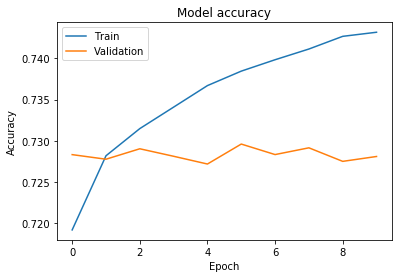

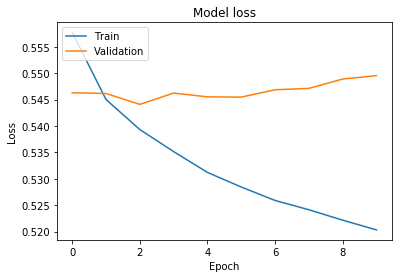

In [63]:
import matplotlib.pyplot as plt

accuracyName = 'accuracyRightQ2W9.png'
lossName = 'lossRightQ2W9.png'

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(accuracyName)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(lossName)
plt.show()




In [64]:
import pickle


pickleName = "Q2Window9Right.pickle"
pkl_filename = "Q2Window9Right.pkl"

pickle_out = open(pickleName,"wb")
pickle.dump(history, pickle_out)
pickle_out.close()


with open(pkl_filename, 'wb') as file:
    pickle.dump(m, file)

TypeError: can't pickle _thread.RLock objects

In [26]:
import pickle

# Save to file in the current working directory
pkl_filename = "Q2Window19MLeft.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m, file)

TypeError: can't pickle _thread.RLock objects

In [65]:
X_test = changeQ8Class(X_test, q8ClassToQ2, numberOfFeatures)
X_test_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_test, classSize)
X_test_window = removeWindowsWithPadding(X_test_window , windowSize, numberOfFeatures)
print(X_train_window.shape)

x_test_final = X_test_window[:,:,0:21]
y_test_final = X_test_window[:,:,21: (21+classSize)]
print(x_test_final.shape)
print(y_test_final.shape)

0
100
200
300
400
500
(1092916, 9, 44)
(81165, 9, 21)
(81165, 9, 2)


In [66]:
scores = m.evaluate(x_test_final, y_test_final)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

81165/81165 [==============================] - 9s 107us/sample - loss: 0.5383 - accuracy: 0.7387 - mae: 0.3673
Loss: 0.5383202852988679, Accuracy: 0.73874617, MAE: 0.3673495


In [26]:
print(history.history)

{'loss': [0.44966836823821205, 0.4156959092493396, 0.4030285179907845, 0.3947629566897908, 0.3889579159463983, 0.3844384876298406, 0.38121293385527116, 0.377806609109231, 0.3749496356954386, 0.37330466704874077], 'accuracy': [0.79195476, 0.81217813, 0.8187889, 0.82314277, 0.8261819, 0.82849085, 0.8299985, 0.8320786, 0.8331986, 0.83413166], 'mae': [0.29131523, 0.26585072, 0.25682375, 0.25105166, 0.24702397, 0.2439069, 0.24171908, 0.2393979, 0.23750165, 0.23633783], 'val_loss': [0.42621516084566147, 0.42289021183940245, 0.422474003301338, 0.42457270685858894, 0.4259774775361735, 0.42797773185014026, 0.4266078387459624, 0.4328603748682463, 0.4322029887590862, 0.43447310772945064], 'val_accuracy': [0.8056156, 0.8059125, 0.80789965, 0.806964, 0.8056692, 0.8068986, 0.80714935, 0.8028684, 0.8046917, 0.80294883], 'val_mae': [0.2793607, 0.27205122, 0.27998343, 0.27230123, 0.27273822, 0.27139467, 0.27769068, 0.2710833, 0.26690817, 0.2731029]}
